In [5]:
# 태양광 발전량 PV 예측 DNN 모델
# pytorch 사용

import torch
import math
import random
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class NeuralNetwork(nn.Module):
    def __init__(self, list_layer):
        super(NeuralNetwork, self).__init__()
        self.layer_list = list_layer
        self.layer_num = 0
        self.activation_num = 0
        self.convolution_num = 0
        self.pool_num = 0

        self.sequential = self.layer_stack(self.layer_list)
        print(self.sequential)

    def forward(self, x):
        i = self.sequential(x)
        return i

    def layer_stack(self, x):
        print(x)
        seq = nn.Sequential()
        for i in x:
            if i[0] == 'ln':
                self.layer_num += 1
                seq.add_module('layer_' + str(self.layer_num) + '_Linear', nn.Linear(i[1], i[2]))
            elif i[0] == 'relu':
                self.activation_num += 1
                seq.add_module('activation_' + str(self.activation_num) + '_Relu', nn.ReLU())
            elif i[0] == 'sigmoid':
                self.activation_num += 1
                seq.add_module('activation_' + str(self.activation_num) + '_Sigmoid', nn.Sigmoid())

        return seq


In [6]:
# 실행환경에 따라 데이터 불러오는 경로 변경 필요
# '/pv_data' 오류 발생시 'pv_data'로
try:
  pv_data = pd.read_csv('pv_data')
except FileNotFoundError:
  pv_data = pd.read_csv('/pv_data')
try:
  weather_data = pd.read_csv('weather_data')
except FileNotFoundError:
  weather_data = pd.read_csv('/weather_data')
dataset = []
start_date = datetime.strptime(weather_data.columns[1],'%Y/%m/%d')
for i in weather_data.columns:
  if i=='Unnamed: 0':
    continue
  day_week = datetime.strptime(i, "%Y/%m/%d")
  for f in range(0,24):
    dataset.append(i.split('/')+[str((day_week-start_date).days),str(day_week.weekday())]+weather_data[i][f].split('/'))
print(dataset)
index=0
for i in pv_data.columns:
  if i=='Unnamed: 0':
    continue
  for f in range(0,24):
    dataset[index]+=[pv_data[i][f]]
    index+=1
print(dataset)
# 년 월 일 경과날짜 요일 시간 온도 강수량 풍속 풍향 습도 일조 일사 전운량 지면온도 발전량

[['2022', '07', '01', '0', '4', '0', '25.6', 'nan', '2.2', '180', '99', 'nan', 'nan', '3.0', '25.0'], ['2022', '07', '01', '0', '4', '1', '25.1', 'nan', '1.4', '200', '99', 'nan', 'nan', '2.0', '24.8'], ['2022', '07', '01', '0', '4', '2', '25.0', 'nan', '1.8', '180', '99', 'nan', 'nan', '4.0', '24.4'], ['2022', '07', '01', '0', '4', '3', '24.9', 'nan', '1.6', '200', '99', 'nan', 'nan', '2.0', '24.2'], ['2022', '07', '01', '0', '4', '4', '24.5', 'nan', '0.4', '0', '99', 'nan', 'nan', '3.0', '24.0'], ['2022', '07', '01', '0', '4', '5', '24.4', 'nan', '1.0', '50', '99', 'nan', 'nan', '3.0', '24.0'], ['2022', '07', '01', '0', '4', '6', '24.0', 'nan', '0.9', '90', '99', '0.1', '0.1', '2.0', '24.0'], ['2022', '07', '01', '0', '4', '7', '25.1', 'nan', '0.9', '70', '99', '1.0', '0.59', '2.0', '24.5'], ['2022', '07', '01', '0', '4', '8', '27.3', 'nan', '2.5', '200', '88', '1.0', '1.29', '2.0', '27.4'], ['2022', '07', '01', '0', '4', '9', '28.4', 'nan', '3.3', '180', '83', '1.0', '1.96', '1.0', 

In [7]:
npdataset = np.array(dataset)
npdataset[npdataset=='nan']='0'
npdataset = npdataset.astype(float)
print(npdataset[0])

[2.022e+03 7.000e+00 1.000e+00 0.000e+00 4.000e+00 0.000e+00 2.560e+01
 0.000e+00 2.200e+00 1.800e+02 9.900e+01 0.000e+00 0.000e+00 3.000e+00
 2.500e+01 0.000e+00]


In [8]:
# 월 일 요일 시간 온도 강수량 습도 전운량 발전량 데이터 선택
# min-max scaling

select_col = [1,2,4,5,6,7,10,13,15]
data_num = len(select_col)-1
print(data_num)
select_data = npdataset[:,select_col]
min_vals = np.min(select_data, axis=0)
max_vals = np.max(select_data, axis=0)
scaled_data = (select_data - min_vals) / (max_vals - min_vals)
print(scaled_data[0])

8
[0.         0.         0.66666667 0.         0.4702381  0.
 1.         0.3        0.00128469]


In [9]:
# 75 : 25 비율로 훈련/검증 데이터셋 분류
def split_data(dset,ratio):
  tx=[]
  ty=[]
  vx=[]
  vy=[]
  for i in dset:
    if(random.uniform(0, 1)<ratio):
      tx.append(i[0:data_num])
      ty.append(i[data_num])
    else:
      vx.append(i[0:data_num])
      vy.append(i[data_num])
  return tx,ty,vx,vy

set_ratio = 0.75

train_X,train_Y,val_X,val_Y = split_data(scaled_data,set_ratio)
train_X=torch.Tensor(train_X).float().to(device)
train_Y=torch.Tensor(train_Y).float().to(device)
val_X=torch.Tensor(val_X).float().to(device)
val_Y=torch.Tensor(val_Y).float().to(device)
print(train_X[0])
print(train_Y[0])

tensor([0.0000, 0.0000, 0.6667, 0.0435, 0.4405, 0.0000, 1.0000, 0.2000])
tensor(0.0013)


<ipython-input-9-622ab2cbcfec>:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  train_X=torch.Tensor(train_X).float().to(device)


In [10]:
# batch size 설정
batch_size = 4
train_loader = DataLoader(TensorDataset(train_X, train_Y), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(TensorDataset(val_X, val_Y), batch_size=batch_size, shuffle=False)

In [11]:
# DNN 모델 생성. 24 * 24 크기의 hidden layer 4개, activation은 relu

list_layer = [['ln', data_num, data_num*4],['relu'],['ln',data_num*4, data_num*4],['relu'],['ln', data_num*4, data_num*4],['relu'],['ln', data_num*4, data_num*4],['relu'],['ln', data_num*4, data_num*4],['relu'],['ln', data_num*4, 1]]

model = NeuralNetwork(list_layer).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

[['ln', 8, 32], ['relu'], ['ln', 32, 32], ['relu'], ['ln', 32, 32], ['relu'], ['ln', 32, 32], ['relu'], ['ln', 32, 32], ['relu'], ['ln', 32, 1]]
Sequential(
  (layer_1_Linear): Linear(in_features=8, out_features=32, bias=True)
  (activation_1_Relu): ReLU()
  (layer_2_Linear): Linear(in_features=32, out_features=32, bias=True)
  (activation_2_Relu): ReLU()
  (layer_3_Linear): Linear(in_features=32, out_features=32, bias=True)
  (activation_3_Relu): ReLU()
  (layer_4_Linear): Linear(in_features=32, out_features=32, bias=True)
  (activation_4_Relu): ReLU()
  (layer_5_Linear): Linear(in_features=32, out_features=32, bias=True)
  (activation_5_Relu): ReLU()
  (layer_6_Linear): Linear(in_features=32, out_features=1, bias=True)
)


In [12]:
#모델 학습

num_epochs = 1000

train_loss=[]
val_loss=[]

vcrit = nn.MSELoss()

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for batch_X, batch_Y in train_loader:
      optimizer.zero_grad()
      outputs = model(batch_X)
      loss = criterion(outputs, batch_Y)
      #rloss = torch.sqrt(loss)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    vrunning_loss = 0.0
    model.eval()
    with torch.no_grad():
        for vbatch_X, vbatch_Y in val_loader:
          voutputs = model(vbatch_X)
          vloss = vcrit(voutputs,vbatch_Y)
          #rvloss = torch.sqrt(vloss)
          vrunning_loss+=vloss.item()

    train_loss.append(running_loss)
    val_loss.append(vrunning_loss)

    if epoch%100==0:
        print('Epoch: %d | Loss: %.4f' % (epoch + 1, running_loss))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, targe

Epoch: 1 | Loss: 16.7608
Epoch: 101 | Loss: 9.0245
Epoch: 201 | Loss: 7.5198
Epoch: 301 | Loss: 7.1879
Epoch: 401 | Loss: 7.0212
Epoch: 501 | Loss: 6.8552
Epoch: 601 | Loss: 6.7618
Epoch: 701 | Loss: 6.6441
Epoch: 801 | Loss: 6.5488
Epoch: 901 | Loss: 6.4304


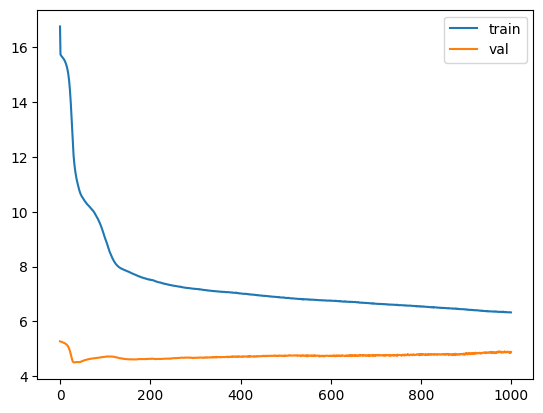

In [13]:
plt.plot(train_loss,label='train')
plt.plot(val_loss,label='val')
plt.legend()
plt.show()

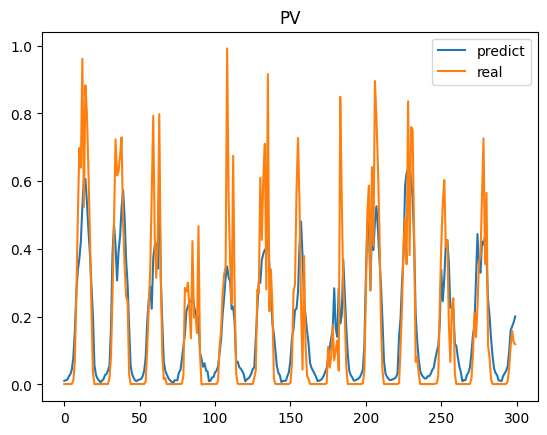

In [18]:
model.eval()
testX = scaled_data[0:300,0:data_num]
testY = scaled_data[0:300,[data_num]]
predictY = model(torch.Tensor(testX))

plt.title('PV')
plt.plot(predictY.detach().numpy(),label='predict')
plt.plot(testY,label='real')
plt.legend()
plt.show()

In [25]:
# 경로에 이상있으면 앞의 '/' 를 제거

torch.save(model,'/pv_fullmodel.pt')
torch.save(model.state_dict(),'/pv_statedict.pt')

[['ln', 8, 32], ['relu'], ['ln', 32, 32], ['relu'], ['ln', 32, 32], ['relu'], ['ln', 32, 32], ['relu'], ['ln', 32, 32], ['relu'], ['ln', 32, 1]]
Sequential(
  (layer_1_Linear): Linear(in_features=8, out_features=32, bias=True)
  (activation_1_Relu): ReLU()
  (layer_2_Linear): Linear(in_features=32, out_features=32, bias=True)
  (activation_2_Relu): ReLU()
  (layer_3_Linear): Linear(in_features=32, out_features=32, bias=True)
  (activation_3_Relu): ReLU()
  (layer_4_Linear): Linear(in_features=32, out_features=32, bias=True)
  (activation_4_Relu): ReLU()
  (layer_5_Linear): Linear(in_features=32, out_features=32, bias=True)
  (activation_5_Relu): ReLU()
  (layer_6_Linear): Linear(in_features=32, out_features=1, bias=True)
)


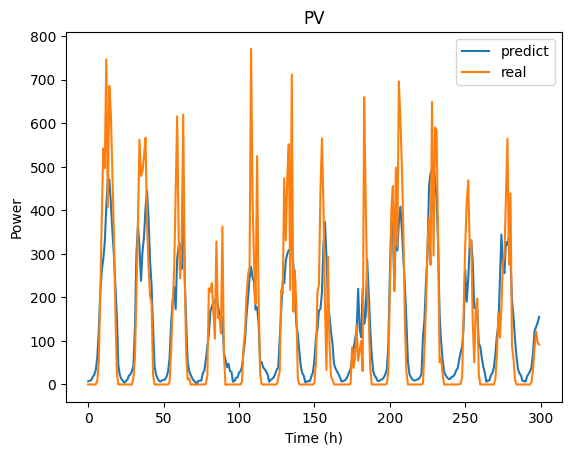

In [27]:
# 모델 저장/불러오기 첫 시간부터 300시간까지의 그래프
test_model = NeuralNetwork(list_layer).to(device)
try:
  test_model.load_state_dict(torch.load('pv_statedict.pt'))
except FileNotFoundError:
  test_model.load_state_dict(torch.load('/pv_statedict.pt'))
test_model.eval()

ptestX = scaled_data[0:300,0:data_num]
ptestY = scaled_data[0:300,[data_num]]
py = test_model(torch.Tensor(ptestX))
py = py.detach().numpy()
#
mn=min_vals[data_num]
mx=max_vals[data_num]

py = py*(mx-mn)
py = py+mn
ptestY = ptestY*(mx-mn)+mn

plt.title('PV')
plt.plot(py,label='predict')
plt.plot(ptestY,label='real')
plt.xlabel('Time (h)')
plt.ylabel('Power')
plt.legend()
plt.show()

[[ -1.1356568 ]
 [  0.48379874]
 [  2.1337075 ]
 [  3.8026967 ]
 [  5.8920884 ]
 [  7.2973967 ]
 [  9.510069  ]
 [ 16.23459   ]
 [ 23.237597  ]
 [180.41841   ]
 [270.73883   ]
 [196.10402   ]
 [331.62378   ]
 [334.84317   ]
 [370.8496    ]
 [112.38946   ]
 [306.82285   ]
 [242.99594   ]
 [ 48.127274  ]
 [ 20.990759  ]
 [ 12.868032  ]
 [  9.379811  ]
 [  6.865749  ]
 [  4.237772  ]]


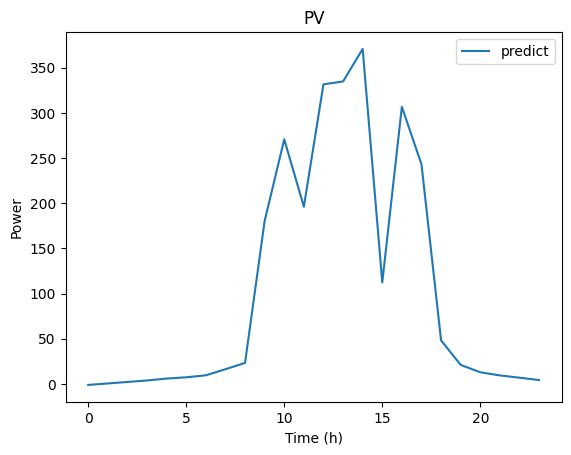

In [29]:
# 2023/8/19(토) 광주광역시 기상예보 기반 발전량 예측
# 월 일 요일 시간 온도 강수량 습도 전운량
# 전운량은 비: 10, 흐림:9, 구름많음:6 구름조금: 3 맑음:0 으로 설정

predictX = np.array([[8,19,5,0,26,0,99,9],
                     [8,19,5,1,26,0,99,9],
                     [8,19,5,2,26,0,99,9],
                     [8,19,5,3,26,0,99,9],
                     [8,19,5,4,25,0,99,9],
                     [8,19,5,5,25,0,99,9],
                     [8,19,5,6,25,0,99,9],
                     [8,19,5,7,25,0,99,9],
                     [8,19,5,8,26,0,99,9],
                     [8,19,5,9,28,0,95,6],
                     [8,19,5,10,29,0,90,6],
                     [8,19,5,11,30,0,85,9],
                     [8,19,5,12,30,0,80,6],
                     [8,19,5,13,31,0,80,6],
                     [8,19,5,14,31,0,80,6],
                     [8,19,5,15,31,4,80,10],
                     [8,19,5,16,30,0,80,6],
                     [8,19,5,17,30,0,85,6],
                     [8,19,5,18,29,0,90,9],
                     [8,19,5,19,28,0,90,9],
                     [8,19,5,20,28,0,95,9],
                     [8,19,5,21,27,0,95,9],
                     [8,19,5,22,27,0,99,9],
                     [8,19,5,23,27,0,99,9]]).astype(float)
predictX = (predictX - min_vals[0:8]) / (max_vals[0:8] - min_vals[0:8])
pdy = test_model(torch.Tensor(predictX))

pdy = pdy.detach().numpy()
pdy = pdy*(mx-mn)
pdy = pdy+mn
print(pdy)
plt.title('PV')
plt.plot(pdy,label='predict')
plt.xlabel('Time (h)')
plt.ylabel('Power')
plt.legend()
plt.show()
